<a href="https://colab.research.google.com/github/jsandtangen/Linear-Regression-Health-Costs-Calculator/blob/main/Linear_Regression_Health_Costs_Calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [10]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2026-01-05 17:41:30--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2026-01-05 17:41:30 (85.6 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [44]:
# Improved preprocessing, feature engineering, splitting, normalization, and training

import numpy as np, random, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# 1) Encode categoricals more appropriately:
#    - smoker and sex -> binary (0/1)
#    - region -> one-hot to avoid ordinal encoding
dataset = pd.read_csv('insurance.csv')  # reload if needed

# Binary mapping for sex and smoker (explicit and interpretable)
dataset['smoker'] = dataset['smoker'].map({'no': 0, 'yes': 1})
dataset['sex']    = dataset['sex'].map({'female': 0, 'male': 1})

# One-hot encode region
dataset = pd.get_dummies(dataset, columns=['region'], prefix='region', drop_first=False)

# 2) Feature engineering (simple, often helpful)
dataset['bmi_sq'] = dataset['bmi'] ** 2
dataset['age_bmi'] = dataset['age'] * dataset['bmi']
dataset['bmi_smoker'] = dataset['bmi'] * dataset['smoker']

# 3) Prepare X,y and ensure deterministic column order
y = dataset['expenses']
X = dataset.drop(columns=['expenses'])

# Optional: reorder columns alphabetically (helps reproducibility)
X = X.reindex(sorted(X.columns), axis=1)

# 4) Train/test split (80/20) with shuffle and fixed random_state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, shuffle=True
)

# 5) Normalization layer adapted on training data
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.asarray(X_train, dtype=np.float32))

# 6) Build slightly stronger but still lightweight model
def make_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(16, activation='relu', kernel_initializer='he_uniform'),
        layers.Dropout(0.1),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])
    return model

model = make_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss='mae',                       # match evaluation metric
    metrics=['mae', 'mse']
)
model.summary()

# 7) Callbacks: EarlyStopping + ReduceLROnPlateau
es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=12, restore_best_weights=True, verbose=1)
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=6, min_lr=1e-5, verbose=1)

# 8) Train (use validation_split to monitor val_mae)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es, rlp],
    verbose=2
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_9 (Normalization) │ (1070, 12)             │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (104.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 25 (104.00 B)

Epoch 1/200
27/27 - 2s - 76ms/step - loss: 13510.7266 - mae: 13510.7266 - mse: 325272000.0000 - val_loss: 12631.5596 - val_mae: 12631.5596 - val_mse: 309800896.0000 - learning_rate: 0.0100
Epoch 2/200
27/27 - 0s - 5ms/step - loss: 13452.4707 - mae: 13452.4707 - mse: 323829920.0000 - val_loss: 12511.2939 - val_mae: 12511.2939 - val_mse: 307032864.0000 - learning_rate: 0.0100
Epoch 3/200
27/27 - 0s - 5ms/step - loss: 13232.0879 - mae: 13232.0879 - mse: 318471264.0000 - val_loss: 12140.7939 - val_mae: 12140.7939 - val_mse: 298799328.0000 - learning_rate: 0.0100
Epoch 4/200
27/27 - 0s - 5ms/step - loss: 12678.2061 - mae: 12678.2061 - mse: 305322400.0000 - val_loss: 11351.9473 - val_mae: 11351.9473 - val_mse: 281458752.0000 - learning_rate: 0.0100
Epoch 5/200
27/27 - 0s - 5ms/step - loss: 11685.1631 - mae: 11685.1631 - mse: 280608896.0000 - val_loss: 10274.4473 - val_mae: 10274.4473 - val_mse: 253576848.0000 - learning_rate: 0.0100
Epoch 6/200
27/27 - 0s - 6ms/step - loss: 10336.1836 - mae:

9/9 - 0s - 6ms/step - loss: 2134.5994 - mae: 2134.5994 - mse: 22407238.0000
Testing set Mean Abs Error: 2134.60 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


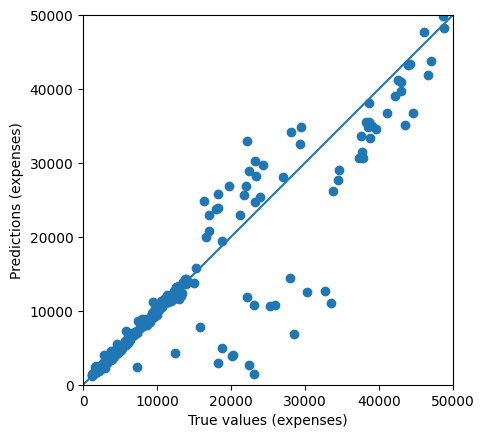

In [45]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)